In [0]:
!pip install --upgrade tables
!pip install eli5

     |████████████████████████████████| 4.3MB 2.4MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4
     |████████████████████████████████| 112kB 2.8MB/s 


In [0]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score
import eli5
from eli5.sklearn import PermutationImportance

In [0]:
cd "/content/drive/My Drive/Colab Notebooks/matrix/matrix_two/dw_matrix_car"

/content/drive/My Drive/Colab Notebooks/matrix/matrix_two/dw_matrix_car


In [0]:
## Wczytywanie danych

In [0]:
df = pd.read_hdf('data/car.h5')
df.shape

(106494, 155)

In [0]:
# sprawdzam kolumny
df.columns
# jest ich 155

Index(['breadcrumb', 'created_at', 'price_currency', 'price_details',
       'price_value', 'seller_address', 'seller_name', 'seller_type',
       'feature_czujniki-parkowania-przednie',
       'feature_poduszka-powietrzna-chroniąca-kolana',
       ...
       'param_pearl', 'param_stan', 'param_wersja', 'param_emisja-co2',
       'param_body-type', 'param_matowy', 'param_bezwypadkowy',
       'param_akryl-(niemetalizowany)', 'param_monthly-payment-value',
       'car_id'],
      dtype='object', length=155)

## Dummy model

In [0]:
# sprawdzam jakie zmienne są typu number
df.select_dtypes(np.number).columns

Index(['price_value', 'car_id'], dtype='object')

In [0]:
feats = ['car_id']
X = df [ feats ].values
y = df ['price_value'].values

# tworzymy nowy model
model=DummyRegressor()

# trenujemy model
model.fit(X,y)

# prognozujemy
y_pred = model.predict(X)

# sprawdzamy błędy wyników (jakość: wartość orginalna - wartosc prognozowana -> średnia z tych wyników)
mae(y, y_pred)

# model myli się o 39 465 PLN/EUR

39465.934630440985

In [0]:
# kolumny zawierające słowo 'price'
[x for x in df.columns if 'price' in x]

['price_currency', 'price_details', 'price_value']

In [0]:
df['price_currency'].value_counts()

PLN    106290
EUR       204
Name: price_currency, dtype: int64

In [0]:
df['price_currency'].value_counts(normalize=True) * 100

PLN    99.80844
EUR     0.19156
Name: price_currency, dtype: float64

In [0]:
# usuwam ogłoszenia z EUR
df = df[ df['price_currency'] != 'EUR' ]
df.shape

(106290, 155)

In [0]:
# przypisuje id dla każdego koloru
df['param_color'].factorize()[0]

array([-1, -1, -1, ..., -1, -1, -1])

## Features

In [0]:
df.head()

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,feature_elektryczne-szyby-przednie,feature_poduszka-powietrzna-pasażera,feature_system-start-stop,feature_światła-do-jazdy-dziennej,feature_komputer-pokładowy,feature_elektryczne-szyby-tylne,feature_klimatyzacja-manualna,feature_tapicerka-welurowa,feature_czujnik-deszczu,feature_światła-przeciwmgielne,feature_ogrzewanie-postojowe,feature_radio-niefabryczne,feature_regulowane-zawieszenie,feature_ogranicznik-prędkości,feature_zmieniarka-cd,feature_szyberdach,feature_isofix,feature_asystent-pasa-ruchu,feature_alufelgi,feature_bluetooth,feature_nawigacja-gps,feature_asystent-parkowania,...,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_make,param_kraj-pochodzenia,param_engine-power,param_year,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_transmission,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_fuel-type,param_vat-free,param_acrylic,param_damaged,param_door-count,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_engine-capacity,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id
0,"[Osobowe, Dacia, Logan, Dacia Logan II (2012-)]","13:23, 5 marca 2018",PLN,Cena Brutto,45100.0,"Krasne 7A - 36-007 Krasne, rzeszowski, Podkarp...",AUTO SPEKTRUM,Dealer,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,...,None,None,Firmy,90 KM,None,None,None,None,None,Benzyna+LPG,None,None,None,None,None,None,None,Logan,898 cm3,None,None,None,None,None,None,None,None,None,Inny kolor,None,None,Nowe,II (2012-),None,None,None,Tak,None,None,0
2,"[Osobowe, Peugeot, 3008, Peugeot 3008 I (2009-...","15:48, 5 marca 2018",PLN,"Cena Brutto, Do negocjacji, Faktura VAT",28000.0,"Tomaszów Mazowiecki, tomaszowski, Łódzkie",None,Osoba prywatna,False,False,False,True,False,False,True,True,True,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,...,None,Tak,Osoby prywatnej,115 KM,None,Polska,None,None,None,Diesel,None,None,None,None,None,None,None,3008,1 560 cm3,None,None,None,None,None,None,None,None,None,Czarny,None,None,Używane,I (2009-2016),None,None,None,Tak,None,None,2
3,"[Osobowe, Porsche, Cayenne, Porsche Cayenne II...","06:30, 4 marca 2018",PLN,"Cena Netto, Do negocjacji, Faktura VAT",229500.0,"Kępińska 24a - 63-640 Bralin, kępiński, Wielko...",P.W. GRIB,Dealer,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,True,True,True,False,True,True,True,True,True,False,True,True,True,True,...,None,None,Firmy,262 KM,None,Niemcy,None,None,Tak,Diesel,Tak,None,None,None,None,None,None,Cayenne,3 000 cm3,None,None,None,None,None,None,None,None,None,Czarny,None,None,Używane,II (2010-),None,None,None,None,None,None,3
4,"[Osobowe, Peugeot, 308, Peugeot 308 T7 (2008-2...","08:46, 3 marca 2018",PLN,"Cena Brutto, Do negocjacji",19500.0,"Limanowa, limanowski, Małopolskie",None,Osoba prywatna,False,False,False,False,False,True,True,True,True,True,True,True,False,False,True,True,False,False,True,True,False,False,False,False,False,False,True,False,True,False,False,False,...,None,Tak,Osoby prywatnej,110 KM,None,Polska,None,None,Tak,Diesel,None,None,None,None,None,None,None,308,1

In [0]:
# faktoryzuje zmienne - czyli przypisuje każdej kategorii id numeryczny
SUFFIX_CAT = '__cat'
for feat in df.columns:
  # ignorujemy listy
 if isinstance(df[feat][0], list): continue

 factorized_values = df[feat].factorize()[0]
#  jeżeli jest cecha która została już poddana faktoryzacji to przypisujemy jej te wartosc po faktoryzacji
 if SUFFIX_CAT in feat:
   df[feat] = factorized_values
 else:
  df[feat + SUFFIX_CAT] =  factorized_values

In [0]:
cat_feats = [x for x in df.columns if SUFFIX_CAT in x]
# ze zbioru zmiennych objaśniajacych wyrzucamy kolumny dotyczące ceny, bo ją prognozujemy
cat_feats = [x for x in cat_feats if 'price' not in x]
len(cat_feats)
# mamy 154 nowe kolumny i 151 bez kolumn z 'price' w nazwie

151

In [0]:
X = df[cat_feats].values
y = df['price_value'].values

model = DecisionTreeRegressor(max_depth=5)
scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_absolute_error')
np.mean(scores)

-19566.588937368324

In [0]:
# sprawdzmy ktore cechy moga byc istotne
m = DecisionTreeRegressor(max_depth=5)
m.fit(X,y)

imp = PermutationImportance(m, random_state=0).fit(X,y)
eli5.show_weights(imp, feature_names=cat_feats)

Weight,Feature
0.2533 ± 0.0040,param_napęd__cat
0.2008 ± 0.0047,param_faktura-vat__cat
0.1943 ± 0.0088,param_stan__cat
0.1423 ± 0.0086,param_rok-produkcji__cat
0.0629 ± 0.0047,param_moc__cat
0.0424 ± 0.0014,feature_kamera-cofania__cat
0.0412 ± 0.0008,param_skrzynia-biegów__cat
0.0286 ± 0.0037,param_marka-pojazdu__cat
0.0191 ± 0.0022,param_pojemność-skokowa__cat
0.0163 ± 0.0005,feature_bluetooth__cat


In [0]:
cat_feats1 = ['param_napęd__cat', 'param_stan__cat', 'param_faktura-vat__cat', 'param_rok-produkcji__cat']
# X = df[ ['param_napęd__cat', 'param_stan__cat', 'param_faktura-vat__cat', 'param_rok-produkcji__cat'] ]
X = df[cat_feats1].values
y = df['price_value'].values

model = DecisionTreeRegressor(max_depth=5)
scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_absolute_error')
np.mean(scores)

-21391.603192781153

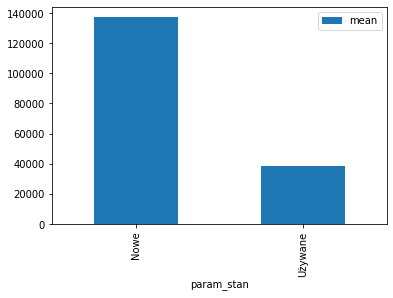

In [0]:
(
 df
#  .groupby('param_napęd')['price_value']
#  .groupby('param_faktura-vat')['price_value']
 .groupby('param_stan')['price_value']
#  .groupby('param_rok-produkcji__cat')['price_value']
 .agg([np.mean])
 
).plot(kind='bar');

In [0]:
# wrzucam na githuba
!git push -u origin master

Branch 'master' set up to track remote branch 'master' from 'origin'.
Everything up-to-date
